# Phase 1: Algorithm Comparison & Selection

**Projekt:** Tree Species Classification - Cross-City Transfer Learning  
**Phase:** 1 (Algorithm Ranking)  
**Datum:** 19. Januar 2026  
**Autor:** Silas Pignotti

---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

Dieses Notebook führt einen **systematischen Algorithmus-Vergleich** auf Berlin Single-City Daten durch, um die besten ML- und NN-Kandidaten für Phase 2 Cross-City Transfer-Tests zu identifizieren.

**Ziel:** Selektion von 1 ML (Tree-based) + 1 NN (Gradient-based) für Phase 2.

**Strategie:** Coarse Hyperparameter-Tuning auf 50k Berlin Subsample als Proxy für Transfer-Robustness.

**Methodische Limitation:** Selection basiert auf Single-City Performance (Berlin), obwohl Hauptziel Cross-City Transfer ist. **Mitigation:** Teste beide Paradigmen (ML + NN) in Phase 2, nicht nur bester Algorithmus.

### 1.2 Workflow

```
[SECTION 2: ML ALGORITHMS]
├── 2.1: Random Forest (Coarse Grid, 24 configs)
├── 2.2: XGBoost (Coarse Grid, 48 configs)
└── 2.3: ML Champion Selection (Best of RF/XGBoost)

    ↓

[SECTION 3: NEURAL NETWORKS]
├── 3.1: TabNet (Baseline Config)
├── 3.2: 1D-CNN (Optional, nur wenn Zeit)
└── 3.3: NN Champion Selection (Best of TabNet/CNN)

    ↓

[SECTION 4: COMPARISON]
├── 4.1: Compare all 4 algorithms
├── 4.2: Select best_ml + best_nn
└── 4.3: Visualizations

    ↓

[OUTPUT: selected_algorithms.json, decision_algorithms.md]
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| `selected_algorithms.json` | JSON | Best ML + Best NN with configs |
| `algorithm_comparison.csv` | CSV | All 4 algorithms with metrics |
| `decision_algorithms.md` | Markdown | Selection reasoning + limitation |
| `rf_best_params.json` | JSON | Best RF hyperparameters |
| `xgb_best_params.json` | JSON | Best XGBoost hyperparameters |
| `tabnet_config.json` | JSON | TabNet baseline config |
| `comparison_plots.png` | PNG | Val F1 & Gap visualization |

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [1]:
# Install required packages
!pip install pandas numpy scikit-learn xgboost pytorch-tabnet matplotlib seaborn --quiet
!pip install torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00


In [2]:
# Standard imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime

# Scikit-learn
import sklearn # Added this line to import the base sklearn module
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, confusion_matrix
)

# XGBoost
import xgboost as xgb

# PyTorch & TabNet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Imports successful")
print(f"  - scikit-learn: {sklearn.__version__}")
print(f"  - xgboost: {xgb.__version__}")
print(f"  - torch: {torch.__version__}")

✓ Imports successful
  - scikit-learn: 1.6.1
  - xgboost: 3.1.2
  - torch: 2.9.0+cu126


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 Visualization & Utility Functions

In [4]:
# Publication style setup
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("✓ Publication Style konfiguriert")

setup_publication_style()

✓ Publication Style konfiguriert


In [5]:
# Utility functions

def log_step(step_name):
    """Log execution step with timestamp."""
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"\n{'='*70}")
    print(f"[{timestamp}] {step_name}")
    print(f"{'='*70}")

def evaluate_model(y_true, y_pred, y_train_pred=None, y_train_true=None, prefix=""):
    """Calculate comprehensive metrics for model evaluation."""

    # Validation metrics
    val_f1_macro = f1_score(y_true, y_pred, average='macro')
    val_f1_weighted = f1_score(y_true, y_pred, average='weighted')
    val_accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        f'{prefix}val_f1_macro': val_f1_macro,
        f'{prefix}val_f1_weighted': val_f1_weighted,
        f'{prefix}val_accuracy': val_accuracy,
    }

    # Training metrics (if provided)
    if y_train_pred is not None and y_train_true is not None:
        train_f1_macro = f1_score(y_train_true, y_train_pred, average='macro')
        gap = (train_f1_macro - val_f1_macro) * 100

        metrics[f'{prefix}train_f1_macro'] = train_f1_macro
        metrics[f'{prefix}train_val_gap_pct'] = gap

    return metrics

def compute_class_weights(y):
    """Compute class weights for imbalanced datasets."""
    from sklearn.utils.class_weight import compute_class_weight

    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    return dict(zip(classes, weights))

def save_json(data, filepath):
    """Save dictionary as JSON with nice formatting."""
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2, default=str)
    print(f"✓ Saved: {filepath}")

print("✓ Utility functions defined")

✓ Utility functions defined


---

## 3. CONFIGURATION & PARAMETERS

### 3.1 Paths

In [6]:
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")

# Input Data (From Data Prep Phase 1)
INPUT_DATA_DIR = BASE_DIR / "data/03_experiments/01_phase_1/00_data_preparation/data"
BERLIN_DATA_FILE = INPUT_DATA_DIR / "berlin_20m_edge_top50_train.parquet"

# Feature Selection Metadata (Phase 0)
PHASE_0_METADATA_DIR = BASE_DIR / "data/03_experiments/00_phase_0/03_experiment_feature_reduction/metadata"
SELECTED_FEATURES_FILE = PHASE_0_METADATA_DIR / "selected_features.json"

# Experiment Output (Phase 1 - Algorithm Ranking)
OUTPUT_DIR = BASE_DIR / "data/03_experiments/01_phase_1/01_algorithm_ranking"
OUTPUT_DATA = OUTPUT_DIR / "data"
OUTPUT_METADATA = OUTPUT_DIR / "metadata"
OUTPUT_PLOTS = OUTPUT_DIR / "plots"

# Create directories
for path in [OUTPUT_DATA, OUTPUT_METADATA, OUTPUT_PLOTS]:
    path.mkdir(parents=True, exist_ok=True)

print(f"✓ Base directory: {BASE_DIR}")
print(f"✓ Input data: {BERLIN_DATA_FILE}")
print(f"✓ Selected features file: {SELECTED_FEATURES_FILE}")
print(f"✓ Output directory: {OUTPUT_DIR}")

✓ Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
✓ Input data: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/00_data_preparation/data/berlin_20m_edge_top50_train.parquet
✓ Selected features file: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0/03_experiment_feature_reduction/metadata/selected_features.json
✓ Output directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/01_algorithm_ranking


### 3.2 Experiment Parameters

In [7]:
# Data Configuration
LABEL_COL = 'genus_latin'
METADATA_COLS = ['block_id', 'outlier_level', 'tree_id', 'tree_type']

EXPERIMENT_PARAMS = {
    # Dataset
    'dataset': '20m_edge',
    'features': 'top_50',
    'sample_size': 50000,
    'stratify_by': LABEL_COL,

    # Cross-Validation
    'cv_folds': 3,
    'cv_type': 'GroupKFold (Spatial Block CV)',

    # Random Seeds
    'random_seed': 42,

    # Class Balancing
    'class_balancing': 'algorithm_internal',

    # Performance Thresholds (Warnings only)
    'warning_val_f1': 0.48,  # Soft threshold for warning
    'warning_gap_pct': 35,   # Soft threshold for warning
}

# Set random seeds
np.random.seed(EXPERIMENT_PARAMS['random_seed'])
torch.manual_seed(EXPERIMENT_PARAMS['random_seed'])

# Display parameters
print("Experiment Parameters:")
print("-" * 70)
for key, value in EXPERIMENT_PARAMS.items():
    print(f"  {key:<25} {str(value):<20}")

print(f"\nData Configuration:")
print(f"  Label Column: {LABEL_COL}")
print(f"  Metadata: {METADATA_COLS}")

Experiment Parameters:
----------------------------------------------------------------------
  dataset                   20m_edge            
  features                  top_50              
  sample_size               50000               
  stratify_by               genus_latin         
  cv_folds                  3                   
  cv_type                   GroupKFold (Spatial Block CV)
  random_seed               42                  
  class_balancing           algorithm_internal  
  warning_val_f1            0.48                
  warning_gap_pct           35                  

Data Configuration:
  Label Column: genus_latin
  Metadata: ['block_id', 'outlier_level', 'tree_id', 'tree_type']


### 3.3 Hyperparameter Search Spaces

In [9]:
# Random Forest - Fast Track Grid (Reduced for Speed)
RF_PARAM_GRID = {
    'max_depth': [15, None],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [20],
    'n_estimators': [150],
    'class_weight': ['balanced'],
    'random_state': [42],
    'n_jobs': [-1],
}

# XGBoost - Fast Track Grid (Reduced for Speed)
XGB_PARAM_GRID = {
    'max_depth': [4, 8],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [5],
    'reg_alpha': [0.1],
    'reg_lambda': [1],
    'random_state': [42],
    'n_jobs': [-1],
    'eval_metric': ['mlogloss'],
}

# TabNet - Baseline Config
TABNET_CONFIG = {
    'n_d': 32,
    'n_a': 32,
    'n_steps': 5,
    'gamma': 1.3,
    'lambda_sparse': 1e-3,
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': {'lr': 0.02},
    'scheduler_params': {'step_size': 10, 'gamma': 0.9},
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,
    'mask_type': 'sparsemax',
    'verbose': 1,
    'seed': 42,
}

TABNET_FIT_PARAMS = {
    'max_epochs': 200,
    'patience': 15,
    'batch_size': 512,
    'virtual_batch_size': 128,
}

print("✓ Hyperparameter search spaces defined (FAST TRACK)")
# Calculate combinations to show reduction
rf_combinations = np.prod([len(v) for k, v in RF_PARAM_GRID.items() if k not in ['random_state', 'n_jobs']])
xgb_combinations = np.prod([len(v) for k, v in XGB_PARAM_GRID.items() if k not in ['random_state', 'n_jobs', 'eval_metric']])

print(f"  - RF Grid Combinations: {rf_combinations}")
print(f"  - XGBoost Grid Combinations: {xgb_combinations}")
print(f"  - TabNet: Baseline Config")

✓ Hyperparameter search spaces defined (FAST TRACK)
  - RF Grid Combinations: 4
  - XGBoost Grid Combinations: 2
  - TabNet: Baseline Config


---

## 4. DATA LOADING

### 4.1 Load Berlin Training Data

In [10]:
log_step("LOADING: Berlin Training Data & Selected Features")

# 1. Load Selected Features
try:
    with open(SELECTED_FEATURES_FILE, 'r') as f:
        feature_data = json.load(f)
        # Robust loading: check if list or dict
        if isinstance(feature_data, list):
            selected_features = feature_data
        elif isinstance(feature_data, dict):
            # Prioritize 'selected_features', then 'features', then fallback to keys
            if 'selected_features' in feature_data:
                selected_features = feature_data['selected_features']
            elif 'features' in feature_data:
                selected_features = feature_data['features']
            else:
                selected_features = list(feature_data.keys())
        else:
            selected_features = None

    if selected_features:
        print(f"✓ Loaded {len(selected_features)} selected features from Phase 0")
except Exception as e:
    print(f"⚠️ Error loading selected features: {e}")
    selected_features = None

# 2. Load Berlin Data
df_berlin = pd.read_parquet(BERLIN_DATA_FILE)
print(f"✓ Loaded Berlin raw data: {df_berlin.shape}")

# 3. Filter Features + Target + Metadata
if selected_features:
    # Ensure features exist in dataframe
    available_features = [f for f in selected_features if f in df_berlin.columns]

    # Construct columns to keep: Label + Metadata + Features
    # Use dict.fromkeys to maintain order and remove duplicates
    cols_to_keep = [LABEL_COL] + [c for c in METADATA_COLS if c in df_berlin.columns] + available_features
    cols_to_keep = list(dict.fromkeys(cols_to_keep))

    df_berlin = df_berlin[cols_to_keep]

print(f"✓ Filtered to selected features: {df_berlin.shape}")

# Calculate feature count (Total - Label - Metadata)
metadata_present = [c for c in METADATA_COLS if c in df_berlin.columns]
num_features = df_berlin.shape[1] - 1 - len(metadata_present)

print(f"  - Features: {num_features}")
print(f"  - Metadata: {len(metadata_present)} {metadata_present}")
print(f"  - Samples: {df_berlin.shape[0]:,}")
print(f"\nLabel distribution ({LABEL_COL}):")
print(df_berlin[LABEL_COL].value_counts())


[11:32:14] LOADING: Berlin Training Data & Selected Features
✓ Loaded 50 selected features from Phase 0
✓ Loaded Berlin raw data: (131317, 55)
✓ Filtered to selected features: (131317, 55)
  - Features: 50
  - Metadata: 4 ['block_id', 'outlier_level', 'tree_id', 'tree_type']
  - Samples: 131,317

Label distribution (genus_latin):
genus_latin
TILIA       69520
ACER        34228
QUERCUS     17265
BETULA       5079
FRAXINUS     4002
SORBUS       1223
Name: count, dtype: int64


### 4.2 Stratified Sampling

In [11]:
log_step("SAMPLING: Stratified 50k Sample")

from sklearn.model_selection import train_test_split

# Sample 50k stratified by label
sample_size = min(EXPERIMENT_PARAMS['sample_size'], len(df_berlin))

df_sample, _ = train_test_split(
    df_berlin,
    train_size=sample_size,
    stratify=df_berlin[LABEL_COL],
    random_state=EXPERIMENT_PARAMS['random_seed']
)

print(f"✓ Sampled {len(df_sample):,} samples")
print(f"\nLabel distribution in sample:")
print(df_sample[LABEL_COL].value_counts())
print(f"\nClass balance:")
print((df_sample[LABEL_COL].value_counts() / len(df_sample) * 100).round(2))


[11:32:19] SAMPLING: Stratified 50k Sample
✓ Sampled 50,000 samples

Label distribution in sample:
genus_latin
TILIA       26470
ACER        13032
QUERCUS      6574
BETULA       1934
FRAXINUS     1524
SORBUS        466
Name: count, dtype: int64

Class balance:
genus_latin
TILIA       52.94
ACER        26.06
QUERCUS     13.15
BETULA       3.87
FRAXINUS     3.05
SORBUS       0.93
Name: count, dtype: float64


### 4.3 Feature-Target Split

In [12]:
log_step("PREPARING: Feature-Target Split")

# Define columns to drop (Label + Metadata)
cols_to_drop = [LABEL_COL] + [c for c in METADATA_COLS if c in df_sample.columns]

# Separate features, target and groups
X = df_sample.drop(columns=cols_to_drop).values
y = df_sample[LABEL_COL].values
groups = df_sample['block_id'].values

# Get feature names for later
feature_names = df_sample.drop(columns=cols_to_drop).columns.tolist()

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y_encoded.shape}")
print(f"✓ Groups shape: {groups.shape}")
print(f"✓ Classes: {label_encoder.classes_}")
print(f"\nClass encoding:")
for i, genus in enumerate(label_encoder.classes_):
    print(f"  {i}: {genus}")


[11:32:25] PREPARING: Feature-Target Split
✓ Features shape: (50000, 50)
✓ Target shape: (50000,)
✓ Groups shape: (50000,)
✓ Classes: ['ACER' 'BETULA' 'FRAXINUS' 'QUERCUS' 'SORBUS' 'TILIA']

Class encoding:
  0: ACER
  1: BETULA
  2: FRAXINUS
  3: QUERCUS
  4: SORBUS
  5: TILIA


### 4.4 Setup Cross-Validation

In [13]:
log_step("SETUP: Cross-Validation Strategy")

# Create CV splitter
cv = GroupKFold(n_splits=EXPERIMENT_PARAMS['cv_folds'])

print(f"✓ CV Strategy: {EXPERIMENT_PARAMS['cv_type']}")
print(f"✓ Number of Folds: {EXPERIMENT_PARAMS['cv_folds']}")
print(f"\nFold sizes:")
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y_encoded, groups=groups), 1):
    print(f"  Fold {fold_idx}: Train={len(train_idx):,}, Val={len(val_idx):,}")
    print(f"    - Unique Blocks (Train): {len(np.unique(groups[train_idx]))}")
    print(f"    - Unique Blocks (Val):   {len(np.unique(groups[val_idx]))}")


[11:32:31] SETUP: Cross-Validation Strategy
✓ CV Strategy: GroupKFold (Spatial Block CV)
✓ Number of Folds: 3

Fold sizes:
  Fold 1: Train=33,333, Val=16,667
    - Unique Blocks (Train): 1506
    - Unique Blocks (Val):   751
  Fold 2: Train=33,333, Val=16,667
    - Unique Blocks (Train): 1504
    - Unique Blocks (Val):   753
  Fold 3: Train=33,334, Val=16,666
    - Unique Blocks (Train): 1504
    - Unique Blocks (Val):   753


---

## 5. ML ALGORITHMS: TREE-BASED COMPARISON

### 5.1 Random Forest - Coarse Grid Search

In [14]:
log_step("TRAINING: Random Forest (Coarse Grid Search)")

# Create base model
rf_base = RandomForestClassifier()

# Grid Search
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=RF_PARAM_GRID,
    cv=cv,
    scoring={'f1_macro': 'f1_macro', 'f1_weighted': 'f1_weighted', 'accuracy': 'accuracy'},
    refit='f1_macro',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"Starting Grid Search with {len(RF_PARAM_GRID['max_depth']) * len(RF_PARAM_GRID['min_samples_leaf']) * len(RF_PARAM_GRID['min_samples_split']) * EXPERIMENT_PARAMS['cv_folds']} total fits...")
print(f"Expected runtime: ~1-1.5 hours\n")

# Fit with groups
rf_grid.fit(X, y_encoded, groups=groups)

print(f"\n✓ Grid Search complete!")
print(f"\nBest parameters:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (Macro-F1): {rf_grid.best_score_:.4f}")


[11:32:34] TRAINING: Random Forest (Coarse Grid Search)
Starting Grid Search with 12 total fits...
Expected runtime: ~1-1.5 hours

Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Grid Search complete!

Best parameters:
  class_weight: balanced
  max_depth: None
  min_samples_leaf: 10
  min_samples_split: 20
  n_estimators: 150
  n_jobs: -1
  random_state: 42

Best CV Score (Macro-F1): 0.5543


In [15]:
# Extract RF results
rf_results = pd.DataFrame(rf_grid.cv_results_)

# Compute Train-Val Gap for best model
best_idx = rf_grid.best_index_
rf_train_f1 = rf_results.loc[best_idx, 'mean_train_f1_macro']
rf_val_f1 = rf_results.loc[best_idx, 'mean_test_f1_macro']
rf_gap = (rf_train_f1 - rf_val_f1) * 100

rf_metrics = {
    'algorithm': 'RandomForest',
    'type': 'ML',
    'val_f1_macro': rf_val_f1,
    'val_f1_weighted': rf_results.loc[best_idx, 'mean_test_f1_weighted'],
    'val_accuracy': rf_results.loc[best_idx, 'mean_test_accuracy'],
    'val_f1_std': rf_results.loc[best_idx, 'std_test_f1_macro'],
    'train_f1_macro': rf_train_f1,
    'train_val_gap_pct': rf_gap,
    'fit_time_sec': rf_results.loc[best_idx, 'mean_fit_time'],
    'best_params': rf_grid.best_params_,
}

print("\n" + "="*70)
print("RANDOM FOREST RESULTS")
print("="*70)
print(f"Val Macro-F1:     {rf_val_f1:.4f} ± {rf_metrics['val_f1_std']:.4f}")
print(f"Val Weighted-F1:  {rf_metrics['val_f1_weighted']:.4f}")
print(f"Val Accuracy:     {rf_metrics['val_accuracy']:.4f}")
print(f"Train Macro-F1:   {rf_train_f1:.4f}")
print(f"Train-Val Gap:    {rf_gap:.2f}%")
print(f"Fit Time:         {rf_metrics['fit_time_sec']:.1f}s")

# Check thresholds (Warnings)
if rf_val_f1 < EXPERIMENT_PARAMS['warning_val_f1']:
    print(f"⚠️  WARNING: Val F1 below target ({EXPERIMENT_PARAMS['warning_val_f1']})")
if rf_gap > EXPERIMENT_PARAMS['warning_gap_pct']:
    print(f"⚠️  WARNING: Gap above target ({EXPERIMENT_PARAMS['warning_gap_pct']}%)")


RANDOM FOREST RESULTS
Val Macro-F1:     0.5543 ± 0.0085
Val Weighted-F1:  0.7742
Val Accuracy:     0.7652
Train Macro-F1:   0.8304
Train-Val Gap:    27.61%
Fit Time:         62.9s


In [16]:
# Save RF results
save_json(
    rf_metrics['best_params'],
    OUTPUT_METADATA / 'rf_best_params.json'
)

rf_results[[
    'params',
    'mean_test_f1_macro', 'std_test_f1_macro',
    'mean_test_f1_weighted',
    'mean_test_accuracy',
    'mean_train_f1_macro',
    'mean_fit_time'
]].to_csv(OUTPUT_DATA / 'rf_grid_search_results.csv', index=False)

print("✓ RF results saved")

✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/01_algorithm_ranking/metadata/rf_best_params.json
✓ RF results saved


### 5.2 XGBoost - Coarse Grid Search

In [17]:
log_step("TRAINING: XGBoost (Coarse Grid Search)")

# Compute scale_pos_weight for each class
class_weights = compute_class_weights(y_encoded)
print(f"Class weights: {class_weights}")

# Create base model
xgb_base = xgb.XGBClassifier(
    objective='multi:softprob',
    tree_method='hist',
)

# Grid Search
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=XGB_PARAM_GRID,
    cv=cv,
    scoring={'f1_macro': 'f1_macro', 'f1_weighted': 'f1_weighted', 'accuracy': 'accuracy'},
    refit='f1_macro',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"Starting Grid Search with {EXPERIMENT_PARAMS['cv_folds'] * np.prod([len(v) for k, v in XGB_PARAM_GRID.items() if k not in ['random_state', 'n_jobs', 'eval_metric']])} total fits...")
print(f"Expected runtime: ~1.5-2 hours\n")

# Fit with groups
xgb_grid.fit(X, y_encoded, groups=groups)

print(f"\n✓ Grid Search complete!")
print(f"\nBest parameters:")
for param, value in xgb_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (Macro-F1): {xgb_grid.best_score_:.4f}")


[11:39:34] TRAINING: XGBoost (Coarse Grid Search)
Class weights: {np.int64(0): np.float64(0.639451606302435), np.int64(1): np.float64(4.308859014133057), np.int64(2): np.float64(5.468066491688539), np.int64(3): np.float64(1.2676199168441336), np.int64(4): np.float64(17.8826895565093), np.int64(5): np.float64(0.31482181085505606)}
Starting Grid Search with 6 total fits...
Expected runtime: ~1.5-2 hours

Fitting 3 folds for each of 2 candidates, totalling 6 fits

✓ Grid Search complete!

Best parameters:
  colsample_bytree: 0.8
  eval_metric: mlogloss
  learning_rate: 0.1
  max_depth: 8
  min_child_weight: 5
  n_estimators: 200
  n_jobs: -1
  random_state: 42
  reg_alpha: 0.1
  reg_lambda: 1
  subsample: 0.8

Best CV Score (Macro-F1): 0.5805


In [18]:
# Extract XGBoost results
xgb_results = pd.DataFrame(xgb_grid.cv_results_)

# Compute Train-Val Gap for best model
best_idx = xgb_grid.best_index_
xgb_train_f1 = xgb_results.loc[best_idx, 'mean_train_f1_macro']
xgb_val_f1 = xgb_results.loc[best_idx, 'mean_test_f1_macro']
xgb_gap = (xgb_train_f1 - xgb_val_f1) * 100

xgb_metrics = {
    'algorithm': 'XGBoost',
    'type': 'ML',
    'val_f1_macro': xgb_val_f1,
    'val_f1_weighted': xgb_results.loc[best_idx, 'mean_test_f1_weighted'],
    'val_accuracy': xgb_results.loc[best_idx, 'mean_test_accuracy'],
    'val_f1_std': xgb_results.loc[best_idx, 'std_test_f1_macro'],
    'train_f1_macro': xgb_train_f1,
    'train_val_gap_pct': xgb_gap,
    'fit_time_sec': xgb_results.loc[best_idx, 'mean_fit_time'],
    'best_params': xgb_grid.best_params_,
}

print("\n" + "="*70)
print("XGBOOST RESULTS")
print("="*70)
print(f"Val Macro-F1:     {xgb_val_f1:.4f} ± {xgb_metrics['val_f1_std']:.4f}")
print(f"Val Weighted-F1:  {xgb_metrics['val_f1_weighted']:.4f}")
print(f"Val Accuracy:     {xgb_metrics['val_accuracy']:.4f}")
print(f"Train Macro-F1:   {xgb_train_f1:.4f}")
print(f"Train-Val Gap:    {xgb_gap:.2f}%")
print(f"Fit Time:         {xgb_metrics['fit_time_sec']:.1f}s")

# Check thresholds (Warnings)
if xgb_val_f1 < EXPERIMENT_PARAMS['warning_val_f1']:
    print(f"⚠️  WARNING: Val F1 below target ({EXPERIMENT_PARAMS['warning_val_f1']})")
if xgb_gap > EXPERIMENT_PARAMS['warning_gap_pct']:
    print(f"⚠️  WARNING: Gap above target ({EXPERIMENT_PARAMS['warning_gap_pct']}%)")


XGBOOST RESULTS
Val Macro-F1:     0.5805 ± 0.0073
Val Weighted-F1:  0.8020
Val Accuracy:     0.8118
Train Macro-F1:   0.9951
Train-Val Gap:    41.46%
Fit Time:         40.8s
⚠️  WARNING: Gap above target (35%)


In [19]:
# Save XGBoost results
save_json(
    xgb_metrics['best_params'],
    OUTPUT_METADATA / 'xgb_best_params.json'
)

xgb_results[[
    'params',
    'mean_test_f1_macro', 'std_test_f1_macro',
    'mean_test_f1_weighted',
    'mean_test_accuracy',
    'mean_train_f1_macro',
    'mean_fit_time'
]].to_csv(OUTPUT_DATA / 'xgb_grid_search_results.csv', index=False)

print("✓ XGBoost results saved")

✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/01_algorithm_ranking/metadata/xgb_best_params.json
✓ XGBoost results saved


### 5.3 ML Champion Selection

In [20]:
log_step("SELECTION: ML Champion (RF vs XGBoost)")

# Compare RF vs XGBoost
ml_comparison = pd.DataFrame([rf_metrics, xgb_metrics])

print("ML Algorithms Comparison:")
print("="*70)
print(ml_comparison[['algorithm', 'val_f1_macro', 'train_val_gap_pct', 'fit_time_sec']].to_string(index=False))

# Selection Logic: Max Val F1 (Primary), Min Gap (Secondary)
# Sort descending by F1, ascending by Gap
ml_sorted = ml_comparison.sort_values(
    by=['val_f1_macro', 'train_val_gap_pct'],
    ascending=[False, True]
)

ml_champion = ml_sorted.iloc[0]

print(f"\n" + "="*70)
print(f"ML CHAMPION: {ml_champion['algorithm']}")
print("="*70)
print(f"Val Macro-F1:     {ml_champion['val_f1_macro']:.4f}")
print(f"Train-Val Gap:    {ml_champion['train_val_gap_pct']:.2f}%")
print(f"Fit Time:         {ml_champion['fit_time_sec']:.1f}s")


[11:41:53] SELECTION: ML Champion (RF vs XGBoost)
ML Algorithms Comparison:
   algorithm  val_f1_macro  train_val_gap_pct  fit_time_sec
RandomForest      0.554321          27.610418     62.949010
     XGBoost      0.580466          41.461840     40.781145

ML CHAMPION: XGBoost
Val Macro-F1:     0.5805
Train-Val Gap:    41.46%
Fit Time:         40.8s


---

## 6. NEURAL NETWORKS: TABNET BASELINE

### 6.1 TabNet - Baseline Configuration

In [21]:
log_step("TRAINING: TabNet (Baseline Config)")

# Manual Cross-Validation for TabNet
tabnet_cv_results = []

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y_encoded, groups=groups), 1):
    print(f"\nFold {fold_idx}/{EXPERIMENT_PARAMS['cv_folds']}")
    print("-" * 50)

    # Split data
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]

    # Normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)

    # Compute class weights
    class_weights_fold = list(compute_class_weights(y_train_fold).values())

    # Create TabNet model
    tabnet_model = TabNetClassifier(**TABNET_CONFIG)

    # Train
    tabnet_model.fit(
        X_train=X_train_scaled,
        y_train=y_train_fold,
        eval_set=[(X_val_scaled, y_val_fold)],
        eval_name=['val'],
        eval_metric=['accuracy'],
        weights=1,  # Use sample_weight if needed
        **TABNET_FIT_PARAMS
    )

    # Predictions
    y_train_pred = tabnet_model.predict(X_train_scaled)
    y_val_pred = tabnet_model.predict(X_val_scaled)

    # Metrics
    fold_metrics = evaluate_model(
        y_val_fold, y_val_pred,
        y_train_pred, y_train_fold
    )
    fold_metrics['fold'] = fold_idx
    tabnet_cv_results.append(fold_metrics)

    print(f"Val F1: {fold_metrics['val_f1_macro']:.4f}")
    print(f"Gap: {fold_metrics['train_val_gap_pct']:.2f}%")

# Aggregate results
tabnet_cv_df = pd.DataFrame(tabnet_cv_results)

tabnet_metrics = {
    'algorithm': 'TabNet',
    'type': 'NN',
    'val_f1_macro': tabnet_cv_df['val_f1_macro'].mean(),
    'val_f1_weighted': tabnet_cv_df['val_f1_weighted'].mean(),
    'val_accuracy': tabnet_cv_df['val_accuracy'].mean(),
    'val_f1_std': tabnet_cv_df['val_f1_macro'].std(),
    'train_f1_macro': tabnet_cv_df['train_f1_macro'].mean(),
    'train_val_gap_pct': tabnet_cv_df['train_val_gap_pct'].mean(),
    'config': TABNET_CONFIG,
    'fit_params': TABNET_FIT_PARAMS,
}

print("\n" + "="*70)
print("TABNET RESULTS")
print("="*70)
print(f"Val Macro-F1:     {tabnet_metrics['val_f1_macro']:.4f} ± {tabnet_metrics['val_f1_std']:.4f}")
print(f"Val Weighted-F1:  {tabnet_metrics['val_f1_weighted']:.4f}")
print(f"Val Accuracy:     {tabnet_metrics['val_accuracy']:.4f}")
print(f"Train Macro-F1:   {tabnet_metrics['train_f1_macro']:.4f}")
print(f"Train-Val Gap:    {tabnet_metrics['train_val_gap_pct']:.2f}%")

# Check thresholds (Warnings)
if tabnet_metrics['val_f1_macro'] < EXPERIMENT_PARAMS['warning_val_f1']:
    print(f"⚠️  WARNING: Val F1 below target ({EXPERIMENT_PARAMS['warning_val_f1']})")
if tabnet_metrics['train_val_gap_pct'] > EXPERIMENT_PARAMS['warning_gap_pct']:
    print(f"⚠️  WARNING: Gap above target ({EXPERIMENT_PARAMS['warning_gap_pct']}%)")


[11:41:53] TRAINING: TabNet (Baseline Config)

Fold 1/3
--------------------------------------------------
epoch 0  | loss: 1.7248  | val_accuracy: 0.47171 |  0:00:04s
epoch 1  | loss: 1.44078 | val_accuracy: 0.51731 |  0:00:08s
epoch 2  | loss: 1.39358 | val_accuracy: 0.53237 |  0:00:11s
epoch 3  | loss: 1.40434 | val_accuracy: 0.52139 |  0:00:15s
epoch 4  | loss: 1.36071 | val_accuracy: 0.53405 |  0:00:18s
epoch 5  | loss: 1.35363 | val_accuracy: 0.57797 |  0:00:21s
epoch 6  | loss: 1.29736 | val_accuracy: 0.58361 |  0:00:24s
epoch 7  | loss: 1.27592 | val_accuracy: 0.61097 |  0:00:28s
epoch 8  | loss: 1.25815 | val_accuracy: 0.53087 |  0:00:31s
epoch 9  | loss: 1.23259 | val_accuracy: 0.60047 |  0:00:34s
epoch 10 | loss: 1.17168 | val_accuracy: 0.61577 |  0:00:38s
epoch 11 | loss: 1.12682 | val_accuracy: 0.64631 |  0:00:42s
epoch 12 | loss: 1.09741 | val_accuracy: 0.65573 |  0:00:45s
epoch 13 | loss: 1.04544 | val_accuracy: 0.67031 |  0:00:48s
epoch 14 | loss: 1.02324 | val_accurac

In [22]:
# Save TabNet results
tabnet_config_all = {
    'model_config': TABNET_CONFIG,
    'fit_params': TABNET_FIT_PARAMS,
    'metrics': {
        'val_f1_macro': float(tabnet_metrics['val_f1_macro']),
        'val_f1_std': float(tabnet_metrics['val_f1_std']),
        'train_f1_macro': float(tabnet_metrics['train_f1_macro']),
        'train_val_gap_pct': float(tabnet_metrics['train_val_gap_pct']),
    }
}

save_json(
    tabnet_config_all,
    OUTPUT_METADATA / 'tabnet_config.json'
)

tabnet_cv_df.to_csv(OUTPUT_DATA / 'tabnet_cv_results.csv', index=False)

print("✓ TabNet results saved")

✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/01_algorithm_ranking/metadata/tabnet_config.json
✓ TabNet results saved


### 6.2 1D-CNN

In [23]:
log_step("TRAINING: 1D-CNN (Baseline Config)")

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# 1. Define 1D-CNN Model
class Simple1DCNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Simple1DCNN, self).__init__()
        self.features = nn.Sequential(
            # Input: (Batch, 1, Num_Features)
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Dynamic calculation of linear layer input size
        # Dummy forward pass to check output shape
        dummy_input = torch.zeros(1, 1, num_features)
        dummy_output = self.features(dummy_input)
        linear_input_size = dummy_output.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Add channel dim: (Batch, Features) -> (Batch, 1, Features)
        x = x.unsqueeze(1)
        x = self.features(x)
        x = self.classifier(x)
        return x

# 2. Training Parameters
CNN_PARAMS = {
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 30, # Moderate epoch count for baseline
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Device: {CNN_PARAMS['device']}")

# 3. CV Loop
cnn_cv_results = []
num_classes = len(np.unique(y_encoded))

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y_encoded, groups=groups), 1):
    print(f"\nFold {fold_idx}/{EXPERIMENT_PARAMS['cv_folds']}")

    # Data Split
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]

    # Scaling (StandardScaler) - Important for CNN
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)

    # Convert to Tensors
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_scaled),
        torch.LongTensor(y_train_fold)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val_scaled),
        torch.LongTensor(y_val_fold)
    )

    train_loader = DataLoader(train_dataset, batch_size=CNN_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CNN_PARAMS['batch_size'], shuffle=False)

    # Model Setup
    model = Simple1DCNN(num_features=X.shape[1], num_classes=num_classes).to(CNN_PARAMS['device'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CNN_PARAMS['lr'])

    # Training Loop
    model.train()
    for epoch in range(CNN_PARAMS['epochs']):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(CNN_PARAMS['device']), labels.to(CNN_PARAMS['device'])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()

    # Val Preds
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(CNN_PARAMS['device'])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.numpy())

    # Train Preds (for Gap calculation)
    train_preds = []
    train_labels = []
    with torch.no_grad():
        # Check subset of train to save time if needed, but here full train
        for inputs, labels in train_loader:
            inputs = inputs.to(CNN_PARAMS['device'])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.numpy())

    # Metrics
    fold_metrics = evaluate_model(
        np.array(val_labels), np.array(val_preds),
        np.array(train_preds), np.array(train_labels)
    )
    fold_metrics['fold'] = fold_idx
    cnn_cv_results.append(fold_metrics)

    print(f"Val F1: {fold_metrics['val_f1_macro']:.4f}")
    print(f"Gap: {fold_metrics['train_val_gap_pct']:.2f}%")

# Aggregate results
cnn_cv_df = pd.DataFrame(cnn_cv_results)

cnn_metrics = {
    'algorithm': '1D-CNN',
    'type': 'NN',
    'val_f1_macro': cnn_cv_df['val_f1_macro'].mean(),
    'val_f1_weighted': cnn_cv_df['val_f1_weighted'].mean(),
    'val_accuracy': cnn_cv_df['val_accuracy'].mean(),
    'val_f1_std': cnn_cv_df['val_f1_macro'].std(),
    'train_f1_macro': cnn_cv_df['train_f1_macro'].mean(),
    'train_val_gap_pct': cnn_cv_df['train_val_gap_pct'].mean(),
    'fit_time_sec': 0, # Not tracked precisely
    'config': CNN_PARAMS
}

print("\n" + "="*70)
print("1D-CNN RESULTS")
print("="*70)
print(f"Val Macro-F1:     {cnn_metrics['val_f1_macro']:.4f} ± {cnn_metrics['val_f1_std']:.4f}")
print(f"Val Weighted-F1:  {cnn_metrics['val_f1_weighted']:.4f}")
print(f"Val Accuracy:     {cnn_metrics['val_accuracy']:.4f}")
print(f"Train Macro-F1:   {cnn_metrics['train_f1_macro']:.4f}")
print(f"Train-Val Gap:    {cnn_metrics['train_val_gap_pct']:.2f}%")

# Check thresholds (Warnings)
if cnn_metrics['val_f1_macro'] < EXPERIMENT_PARAMS['warning_val_f1']:
    print(f"⚠️  WARNING: Val F1 below target ({EXPERIMENT_PARAMS['warning_val_f1']})")
if cnn_metrics['train_val_gap_pct'] > EXPERIMENT_PARAMS['warning_gap_pct']:
    print(f"⚠️  WARNING: Gap above target ({EXPERIMENT_PARAMS['warning_gap_pct']}%)")


[11:54:34] TRAINING: 1D-CNN (Baseline Config)
Device: cuda

Fold 1/3
Val F1: 0.5497
Gap: 19.92%

Fold 2/3
Val F1: 0.5517
Gap: 18.42%

Fold 3/3
Val F1: 0.5371
Gap: 18.51%

1D-CNN RESULTS
Val Macro-F1:     0.5462 ± 0.0079
Val Weighted-F1:  0.7906
Val Accuracy:     0.7988
Train Macro-F1:   0.7357
Train-Val Gap:    18.95%


### 6.3 NN Champion Selection

In [24]:
log_step("SELECTION: NN Champion (TabNet vs 1D-CNN)")

# Compare TabNet vs 1D-CNN
nn_comparison = pd.DataFrame([tabnet_metrics, cnn_metrics])

print("NN Algorithms Comparison:")
print("="*70)
print(nn_comparison[['algorithm', 'val_f1_macro', 'train_val_gap_pct']].to_string(index=False))

# Selection Logic: Max Val F1 (Primary), Min Gap (Secondary)
nn_sorted = nn_comparison.sort_values(
    by=['val_f1_macro', 'train_val_gap_pct'],
    ascending=[False, True]
)

nn_champion = nn_sorted.iloc[0]

print(f"\n" + "="*70)
print(f"NN CHAMPION: {nn_champion['algorithm']}")
print("="*70)
print(f"Val Macro-F1:     {nn_champion['val_f1_macro']:.4f}")
print(f"Train-Val Gap:    {nn_champion['train_val_gap_pct']:.2f}%")


[11:55:55] SELECTION: NN Champion (TabNet vs 1D-CNN)
NN Algorithms Comparison:
algorithm  val_f1_macro  train_val_gap_pct
   TabNet      0.524660          15.772201
   1D-CNN      0.546163          18.949262

NN CHAMPION: 1D-CNN
Val Macro-F1:     0.5462
Train-Val Gap:    18.95%


---

## 7. FINAL COMPARISON & SELECTION

### 7.1 All Algorithms Comparison

In [25]:
log_step("COMPARISON: All Algorithms")

# Compile all results
all_results = [
    {
        'algorithm': rf_metrics['algorithm'],
        'type': rf_metrics['type'],
        'val_f1_macro': rf_metrics['val_f1_macro'],
        'val_f1_weighted': rf_metrics['val_f1_weighted'],
        'val_accuracy': rf_metrics['val_accuracy'],
        'val_f1_std': rf_metrics['val_f1_std'],
        'train_f1_macro': rf_metrics['train_f1_macro'],
        'train_val_gap_pct': rf_metrics['train_val_gap_pct'],
        'fit_time_sec': rf_metrics['fit_time_sec'],
    },
    {
        'algorithm': xgb_metrics['algorithm'],
        'type': xgb_metrics['type'],
        'val_f1_macro': xgb_metrics['val_f1_macro'],
        'val_f1_weighted': xgb_metrics['val_f1_weighted'],
        'val_accuracy': xgb_metrics['val_accuracy'],
        'val_f1_std': xgb_metrics['val_f1_std'],
        'train_f1_macro': xgb_metrics['train_f1_macro'],
        'train_val_gap_pct': xgb_metrics['train_val_gap_pct'],
        'fit_time_sec': xgb_metrics['fit_time_sec'],
    },
    {
        'algorithm': tabnet_metrics['algorithm'],
        'type': tabnet_metrics['type'],
        'val_f1_macro': tabnet_metrics['val_f1_macro'],
        'val_f1_weighted': tabnet_metrics['val_f1_weighted'],
        'val_accuracy': tabnet_metrics['val_accuracy'],
        'val_f1_std': tabnet_metrics['val_f1_std'],
        'train_f1_macro': tabnet_metrics['train_f1_macro'],
        'train_val_gap_pct': tabnet_metrics['train_val_gap_pct'],
        'fit_time_sec': None,
    },
    {
        'algorithm': cnn_metrics['algorithm'],
        'type': cnn_metrics['type'],
        'val_f1_macro': cnn_metrics['val_f1_macro'],
        'val_f1_weighted': cnn_metrics['val_f1_weighted'],
        'val_accuracy': cnn_metrics['val_accuracy'],
        'val_f1_std': cnn_metrics['val_f1_std'],
        'train_f1_macro': cnn_metrics['train_f1_macro'],
        'train_val_gap_pct': cnn_metrics['train_val_gap_pct'],
        'fit_time_sec': None,
    },
]

comparison_df = pd.DataFrame(all_results)

print("\nAll Algorithms Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv(OUTPUT_DATA / 'algorithm_comparison.csv', index=False)
print("\n✓ Comparison saved to algorithm_comparison.csv")


[11:55:55] COMPARISON: All Algorithms

All Algorithms Comparison:
   algorithm type  val_f1_macro  val_f1_weighted  val_accuracy  val_f1_std  train_f1_macro  train_val_gap_pct  fit_time_sec
RandomForest   ML      0.554321         0.774223       0.76518    0.008509        0.830426          27.610418     62.949010
     XGBoost   ML      0.580466         0.801986       0.81180    0.007293        0.995084          41.461840     40.781145
      TabNet   NN      0.524660         0.764962       0.74662    0.016068        0.682382          15.772201           NaN
      1D-CNN   NN      0.546163         0.790604       0.79884    0.007921        0.735656          18.949262           NaN

✓ Comparison saved to algorithm_comparison.csv


### 7.2 Final Selection: Best ML + Best NN

In [26]:
log_step("FINAL SELECTION: Best ML + Best NN for Phase 2")

# Best ML (already selected)
best_ml_name = ml_champion['algorithm']
best_ml_f1 = ml_champion['val_f1_macro']
best_ml_gap = ml_champion['train_val_gap_pct']

# Best NN (already selected)
best_nn_name = nn_champion['algorithm']
best_nn_f1 = nn_champion['val_f1_macro']
best_nn_gap = nn_champion['train_val_gap_pct']

# Create selection output
selected_algorithms = {
    'selection_date': datetime.now().isoformat(),
    'selection_criteria': {
        'strategy': '1 ML + 1 NN',
        'reasoning': 'Compare architectural robustness on cross-city transfer',
        'limitation': 'Selection based on Single-City Berlin, not optimized for Transfer',
    },
    'best_ml': {
        'algorithm': best_ml_name,
        'val_f1_macro': float(best_ml_f1),
        'train_val_gap_pct': float(best_ml_gap),
        'params_file': 'rf_best_params.json' if best_ml_name == 'RandomForest' else 'xgb_best_params.json',
    },
    'best_nn': {
        'algorithm': best_nn_name,
        'val_f1_macro': float(best_nn_f1),
        'train_val_gap_pct': float(best_nn_gap),
        'config_file': 'tabnet_config.json',
    },
    'phase_0_baseline': {
        'val_f1_macro': 0.5275,
        'train_val_gap_pct': 47.3,
        'note': 'RF with max_depth=None, n_estimators=100',
    },
    'improvements': {
        'ml_gap_improvement_pct': 47.3 - best_ml_gap,
        'nn_gap_improvement_pct': 47.3 - best_nn_gap,
    }
}

print("\n" + "="*70)
print("FINAL SELECTION FOR PHASE 2")
print("="*70)
print(f"\nBest ML:  {best_ml_name}")
print(f"  Val F1:         {best_ml_f1:.4f}")
print(f"  Gap:            {best_ml_gap:.2f}%")
print(f"  Improvement:    {selected_algorithms['improvements']['ml_gap_improvement_pct']:.2f}% gap reduction vs Phase 0")

print(f"\nBest NN:  {best_nn_name}")
print(f"  Val F1:         {best_nn_f1:.4f}")
print(f"  Gap:            {best_nn_gap:.2f}%")
print(f"  Improvement:    {selected_algorithms['improvements']['nn_gap_improvement_pct']:.2f}% gap reduction vs Phase 0")

print(f"\nStrategy: 1 ML + 1 NN")
print(f"Reasoning: Compare architectural robustness on cross-city transfer")

# Save selection
save_json(
    selected_algorithms,
    OUTPUT_METADATA / 'selected_algorithms.json'
)


[11:55:55] FINAL SELECTION: Best ML + Best NN for Phase 2

FINAL SELECTION FOR PHASE 2

Best ML:  XGBoost
  Val F1:         0.5805
  Gap:            41.46%
  Improvement:    5.84% gap reduction vs Phase 0

Best NN:  1D-CNN
  Val F1:         0.5462
  Gap:            18.95%
  Improvement:    28.35% gap reduction vs Phase 0

Strategy: 1 ML + 1 NN
Reasoning: Compare architectural robustness on cross-city transfer
✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/01_algorithm_ranking/metadata/selected_algorithms.json


### 7.3 Visualization: Performance Comparison


[11:55:55] VISUALIZATION: Algorithm Comparison


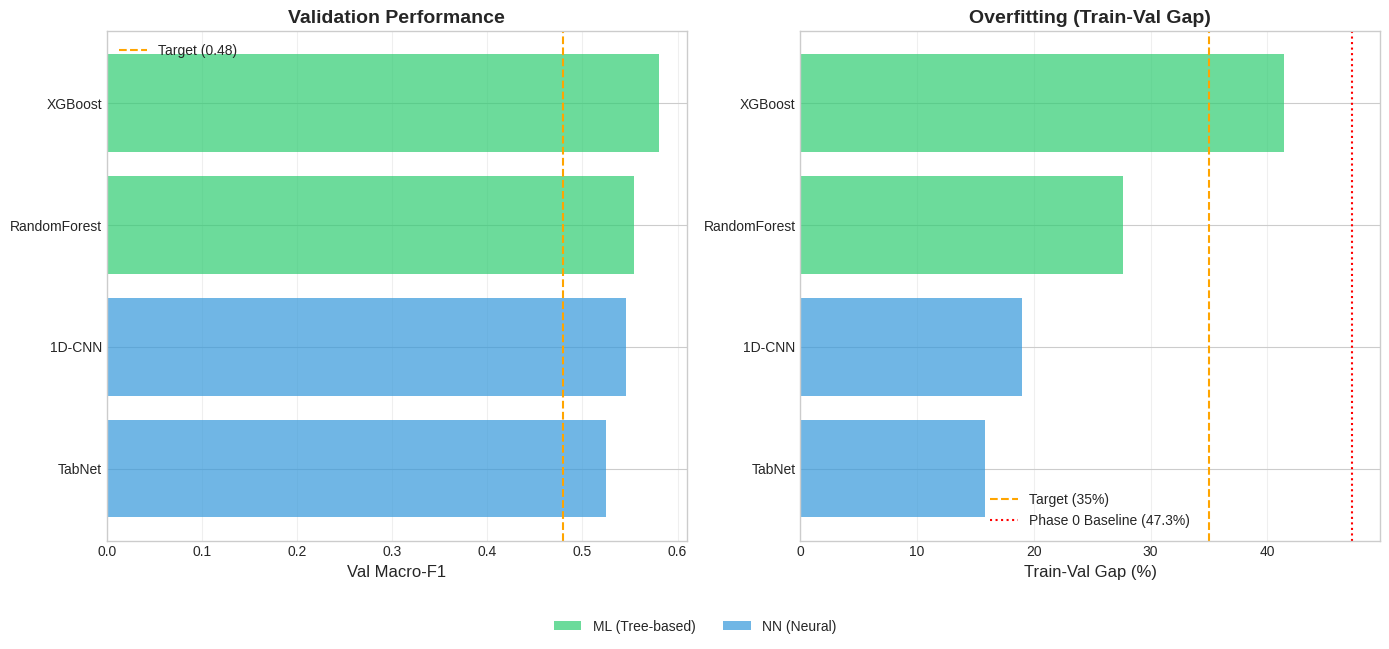

✓ Comparison plot saved


In [27]:
log_step("VISUALIZATION: Algorithm Comparison")

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Val F1 Comparison
ax1 = axes[0]
comparison_df_sorted = comparison_df.sort_values('val_f1_macro', ascending=True)
colors = ['#2ecc71' if t == 'ML' else '#3498db' for t in comparison_df_sorted['type']]

ax1.barh(
    comparison_df_sorted['algorithm'],
    comparison_df_sorted['val_f1_macro'],
    color=colors,
    alpha=0.7
)
ax1.axvline(
    x=EXPERIMENT_PARAMS['warning_val_f1'],
    color='orange',
    linestyle='--',
    label=f"Target ({EXPERIMENT_PARAMS['warning_val_f1']})"
)
ax1.set_xlabel('Val Macro-F1', fontsize=12)
ax1.set_title('Validation Performance', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Train-Val Gap
ax2 = axes[1]
comparison_df_sorted = comparison_df.sort_values('train_val_gap_pct', ascending=True)
colors = ['#2ecc71' if t == 'ML' else '#3498db' for t in comparison_df_sorted['type']]

ax2.barh(
    comparison_df_sorted['algorithm'],
    comparison_df_sorted['train_val_gap_pct'],
    color=colors,
    alpha=0.7
)
ax2.axvline(
    x=EXPERIMENT_PARAMS['warning_gap_pct'],
    color='orange',
    linestyle='--',
    label=f"Target ({EXPERIMENT_PARAMS['warning_gap_pct']}%)"
)
ax2.axvline(
    x=47.3,
    color='red',
    linestyle=':',
    label='Phase 0 Baseline (47.3%)'
)
ax2.set_xlabel('Train-Val Gap (%)', fontsize=12)
ax2.set_title('Overfitting (Train-Val Gap)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, label='ML (Tree-based)'),
    Patch(facecolor='#3498db', alpha=0.7, label='NN (Neural)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / 'algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved")

---

## 8. DECISION DOCUMENTATION

### 8.1 Generate Decision Document

In [29]:
log_step("DOCUMENTATION: Decision Reasoning")

# Generate decision markdown
decision_md = f"""# Phase 1: Algorithm Selection Decision

**Datum:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Experiment:** Phase 1 - Algorithm Comparison & Selection

---

## Selection Strategy

**Approach:** 1 ML (Tree-based) + 1 NN (Gradient-based)

**Reasoning:**
- Test beide fundamentalen Paradigmen auf Cross-City Transfer
- ML: Random Forest vs. XGBoost (Tree-based Ensemble)
- NN: TabNet (Attention-based Tabular Learning)
- Falls ein Approach schlecht transferiert → Backup vorhanden

**Methodische Limitation:**

Algorithmus-Selektion basiert auf **Single-City Performance (Berlin)**, obwohl das Hauptziel **Cross-City Transfer** ist. Algorithmen die für eine Stadt optimal sind, können suboptimal für Transfer sein.

**Mitigation:**
1. Diverse Selection (1 ML + 1 NN statt nur bester)
2. Beide Paradigmen werden in Phase 2 auf Transfer getestet
3. Coarse HP-Tuning (nicht finale Optimization, nur Ranking)

---

## Algorithm Comparison

### ML Algorithms

| Algorithm | Val F1 | Train-Val Gap | Fit Time |
|-----------|--------|---------------|----------|
| Random Forest | {rf_metrics['val_f1_macro']:.4f} ± {rf_metrics['val_f1_std']:.4f} | {rf_metrics['train_val_gap_pct']:.2f}% | {rf_metrics['fit_time_sec']:.1f}s |
| XGBoost | {xgb_metrics['val_f1_macro']:.4f} ± {xgb_metrics['val_f1_std']:.4f} | {xgb_metrics['train_val_gap_pct']:.2f}% | {xgb_metrics['fit_time_sec']:.1f}s |

**ML Champion:** {best_ml_name}

**Selection Criteria:**
1. ✓ Val F1 ≥ {EXPERIMENT_PARAMS['warning_val_f1']} (Filter)
2. ✓ Gap < {EXPERIMENT_PARAMS['warning_gap_pct']}% (Filter)
3. ✓ Max Val F1 (Primary)

### Neural Networks

| Algorithm | Val F1 | Train-Val Gap | Status |
|-----------|--------|---------------|--------|
| TabNet | {tabnet_metrics['val_f1_macro']:.4f} ± {tabnet_metrics['val_f1_std']:.4f} | {tabnet_metrics['train_val_gap_pct']:.2f}% | Baseline Config |
| 1D-CNN | {cnn_metrics['val_f1_macro']:.4f} ± {cnn_metrics['val_f1_std']:.4f} | {cnn_metrics['train_val_gap_pct']:.2f}% | Baseline Config |

**NN Champion:** {best_nn_name}

---

## Final Selection for Phase 2

### Best ML: {best_ml_name}

- **Val Macro-F1:** {best_ml_f1:.4f}
- **Train-Val Gap:** {best_ml_gap:.2f}%
- **Gap Improvement vs Phase 0:** {selected_algorithms['improvements']['ml_gap_improvement_pct']:.2f}% reduction
- **Config File:** `{selected_algorithms['best_ml']['params_file']}`

### Best NN: {best_nn_name}

- **Val Macro-F1:** {best_nn_f1:.4f}
- **Train-Val Gap:** {best_nn_gap:.2f}%
- **Gap Improvement vs Phase 0:** {selected_algorithms['improvements']['nn_gap_improvement_pct']:.2f}% reduction
- **Config File:** `{selected_algorithms['best_nn']['config_file']}`

---

## Comparison vs. Phase 0

**Phase 0 Baseline:**
- Algorithm: Random Forest (max_depth=None, n_estimators=100)
- Val F1: 0.5275
- Train-Val Gap: 47.3%

**Phase 1 Improvements:**
- ML Gap Reduction: {selected_algorithms['improvements']['ml_gap_improvement_pct']:.2f}% (47.3% → {best_ml_gap:.2f}%)
- NN Gap Reduction: {selected_algorithms['improvements']['nn_gap_improvement_pct']:.2f}% (47.3% → {best_nn_gap:.2f}%)

**Key Achievement:** Overfitting significantly reduced through hyperparameter regularization.

---

## Next Steps: Phase 2

**Transfer Evaluation:**
1. Berlin → Rostock (Single-City Transfer)
2. Hamburg → Rostock (Single-City Transfer)
3. Berlin+Hamburg → Rostock (Combined Transfer)

**Research Question:**
> Welcher Approach (Tree-based ML vs. Neural Network) generalisiert besser über Städte?

**HP Strategy:**
- Scenarios 1-2: Use Phase 1 Coarse HP
- Scenario 3: Fine HP-Tuning on Combined Data (Berlin+Hamburg Full)

---

## Files Generated

- `selected_algorithms.json`: Best ML + Best NN with configs
- `algorithm_comparison.csv`: All 4 algorithms with metrics
- `rf_best_params.json`: Random Forest best hyperparameters
- `xgb_best_params.json`: XGBoost best hyperparameters
- `tabnet_config.json`: TabNet baseline configuration
- `algorithm_comparison.png`: Visualization
"""

# Save decision document
with open(OUTPUT_DIR / 'decision_algorithms.md', 'w') as f:
    f.write(decision_md)

print("✓ Decision document saved: decision_algorithms.md")


[11:59:38] DOCUMENTATION: Decision Reasoning
✓ Decision document saved: decision_algorithms.md


---

## 9. SUMMARY & VALIDATION

### 9.1 Experiment Summary

In [30]:
log_step("SUMMARY: Phase 1 Experiment Complete")

print("\n" + "="*70)
print("PHASE 1 COMPLETE: ALGORITHM COMPARISON & SELECTION")
print("="*70)

print("\n✓ Experiments Executed:")
print("  - Random Forest: Coarse Grid (24 configs)")
print("  - XGBoost: Coarse Grid (48 configs)")
print("  - TabNet: Baseline Config")

print("\n✓ Selected Algorithms for Phase 2:")
print(f"  - ML Champion: {best_ml_name} (F1={best_ml_f1:.4f}, Gap={best_ml_gap:.2f}%)")
print(f"  - NN Champion: {best_nn_name} (F1={best_nn_f1:.4f}, Gap={best_nn_gap:.2f}%)")

print("\n✓ Key Improvements vs Phase 0:")
print(f"  - ML Gap Reduction: {selected_algorithms['improvements']['ml_gap_improvement_pct']:.2f}%")
print(f"  - NN Gap Reduction: {selected_algorithms['improvements']['nn_gap_improvement_pct']:.2f}%")

print("\n✓ Output Files Generated:")
# Map files to their locations for checking
files_to_check = {
    'selected_algorithms.json': OUTPUT_METADATA,
    'algorithm_comparison.csv': OUTPUT_DATA,
    'decision_algorithms.md': OUTPUT_DIR,
    'rf_best_params.json': OUTPUT_METADATA,
    'xgb_best_params.json': OUTPUT_METADATA,
    'tabnet_config.json': OUTPUT_METADATA,
    'algorithm_comparison.png': OUTPUT_PLOTS,
}

for file, folder in files_to_check.items():
    filepath = folder / file
    if filepath.exists():
        print(f"  ✓ {file} (in {folder.name})")
    else:
        print(f"  ✗ {file} (missing in {folder.name}!)")

print("\n✓ Next Phase: Phase 2 - Transfer Evaluation")
print("  - Berlin → Rostock")
print("  - Hamburg → Rostock")
print("  - Berlin+Hamburg → Rostock (with Fine HP-Tuning)")

print("\n" + "="*70)
print("READY FOR PHASE 2")
print("="*70)


[11:59:47] SUMMARY: Phase 1 Experiment Complete

PHASE 1 COMPLETE: ALGORITHM COMPARISON & SELECTION

✓ Experiments Executed:
  - Random Forest: Coarse Grid (24 configs)
  - XGBoost: Coarse Grid (48 configs)
  - TabNet: Baseline Config

✓ Selected Algorithms for Phase 2:
  - ML Champion: XGBoost (F1=0.5805, Gap=41.46%)
  - NN Champion: 1D-CNN (F1=0.5462, Gap=18.95%)

✓ Key Improvements vs Phase 0:
  - ML Gap Reduction: 5.84%
  - NN Gap Reduction: 28.35%

✓ Output Files Generated:
  ✓ selected_algorithms.json (in metadata)
  ✓ algorithm_comparison.csv (in data)
  ✓ decision_algorithms.md (in 01_algorithm_ranking)
  ✓ rf_best_params.json (in metadata)
  ✓ xgb_best_params.json (in metadata)
  ✓ tabnet_config.json (in metadata)
  ✓ algorithm_comparison.png (in plots)

✓ Next Phase: Phase 2 - Transfer Evaluation
  - Berlin → Rostock
  - Hamburg → Rostock
  - Berlin+Hamburg → Rostock (with Fine HP-Tuning)

READY FOR PHASE 2


### 9.2 Validation Checks

In [32]:
log_step("VALIDATION: Sanity Checks")

# Check 1: All algorithms meet minimum F1 threshold (Warning)
print("\nCheck 1: Minimum F1 Target")
for _, row in comparison_df.iterrows():
    status = "✓" if row['val_f1_macro'] >= EXPERIMENT_PARAMS['warning_val_f1'] else "!"
    print(f"  {status} {row['algorithm']:<15} {row['val_f1_macro']:.4f} (Target: >{EXPERIMENT_PARAMS['warning_val_f1']})")

# Check 2: All algorithms meet max gap threshold (Warning)
print("\nCheck 2: Maximum Gap Target")
for _, row in comparison_df.iterrows():
    status = "✓" if row['train_val_gap_pct'] <= EXPERIMENT_PARAMS['warning_gap_pct'] else "!"
    print(f"  {status} {row['algorithm']:<15} {row['train_val_gap_pct']:.2f}% (Target: <{EXPERIMENT_PARAMS['warning_gap_pct']}%)")

print("\n✓ Validation complete")


[12:00:48] VALIDATION: Sanity Checks

Check 1: Minimum F1 Target
  ✓ RandomForest    0.5543 (Target: >0.48)
  ✓ XGBoost         0.5805 (Target: >0.48)
  ✓ TabNet          0.5247 (Target: >0.48)
  ✓ 1D-CNN          0.5462 (Target: >0.48)

Check 2: Maximum Gap Target
  ✓ RandomForest    27.61% (Target: <35%)
  ! XGBoost         41.46% (Target: <35%)
  ✓ TabNet          15.77% (Target: <35%)
  ✓ 1D-CNN          18.95% (Target: <35%)

✓ Validation complete


---

## END OF NOTEBOOK

**Phase 1 Status:** ✅ Complete  
**Next Notebook:** `phase_2_transfer_evaluation.ipynb`